In [22]:
# if running in Google Colab:
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TimeSeriesForecasting')
!pwd

NameError: name 'drive' is not defined

In [23]:
import glob
import itertools

import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

from model import Model
from train import Trainer, visualize_predictions
from utils import TimeSeriesDataset, plot_training_history, compare_experiments, print_experiment_summary

## Training Parameters

In [24]:
DATA_PATH = './data/*.csv'
BATCH_SIZE = 8
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-3
LOOKBACK_STEPS = 336
FORECAST_STEPS = 96


## Preprocess Data

In [25]:
csv_files = sorted(glob.glob(DATA_PATH))
dfs = [pd.read_csv(file, encoding='latin1') for file in csv_files]
df = pd.concat(dfs, ignore_index=True)
data = df.iloc[:, 1:].copy()
data = data.replace(-9999, np.nan).ffill().dropna()

for col in data.columns:
    mean = data[col].mean()
    std = data[col].std()
    data = data[(data[col] >= mean - 3 * std) & (data[col] <= mean + 3 * std)]

data = data.values
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
# pd.DataFrame(data_normalized).hist(bins=50, figsize=(20, 15)) # uncomment to visualize feature distributions

## Create Dataset and Initialize Model

Change model configs here

In [26]:
train_size = int(0.8 * len(data_normalized))
train_data = TimeSeriesDataset(data_normalized[:train_size], lookback=LOOKBACK_STEPS, forecast=FORECAST_STEPS)
test_data = TimeSeriesDataset(data_normalized[train_size:], lookback=LOOKBACK_STEPS, forecast=FORECAST_STEPS)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Train data shape: {len(train_data)}")
print(f"Test data shape: {len(test_data)}")

model = Model(
    num_variates=data_normalized.shape[1],
    lookback_steps=LOOKBACK_STEPS,
    forecast_steps=FORECAST_STEPS,

    d_model=128,  # Embedding dimension (same for both streams)

    # Stream 1: iTransformer
    n_heads_s1=4,
    n_layers_s1=2,
    d_ff_s1=128,
    dropout_s1=0.3,

    # Stream 2: Powerformer
    patch_len=2,
    stride=8,
    n_heads_s2=4,
    n_layers_s2=2,
    d_ff_s2=128,
    dropout_s2=0.3,
    attn_decay_scale=0.5,

    # Fusion
    n_heads_fusion=2,
)


Train data shape: 34260
Test data shape: 8242


## Train Model

In [27]:
# Initialize trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

Model initialized on cpu
Total parameters: 1,319,105
Trainable parameters: 1,319,105


Change training configs here 

In [28]:
history = trainer.train(
    num_epochs=2,                            # Number of training epochs
    use_scheduler=True,                      # Enable ReduceLROnPlateau scheduler
    scheduler_factor=0.5,                    # LR reduction factor (new_lr = lr * factor)
    scheduler_patience=1,                    # Epochs to wait before reducing LR
    save_dir='./experiments',                # Directory to save models and metrics
    save_metrics=True,                       # Save training metrics as JSON
    experiment_name='small_cpu',                  # Name for this experiment (used in filenames)
    results_file='all_experiments.json',     # Shared file for all experiments (None for individual files)
    append_results=True,                     # Append to results_file (False to overwrite)
    plot_predictions=True,                   # Generate prediction plots at end of training
    num_plot_samples=5,                      # Number of random samples to visualize
    num_plot_variates=4                      # Number of variates to show per sample
)



Starting training: 2 epochs
Scheduler: Enabled




Epoch 2/2 Summary:
  Train Loss: 0.485288
  Val Loss:   0.275117
  Val MAE:    0.313753
  LR:         1.00e-03


Training completed!

Model saved: ./experiments\model_small_cpu_20251206_235330.pth
Appending to existing results file (2 experiments total)
Results saved: ./experiments\all_experiments.json

Final Results:
  Train Loss (MSE): 0.485288
  Test Loss (MSE):  0.275117
  Test MAE:         0.313753
  Best Test Loss:   0.275117 (epoch 2)
  Best Test MAE:    0.313753 (epoch 2)

Generating prediction plots...
Prediction plot saved: ./experiments\predictions_20251206_235330.png


## Visualize results

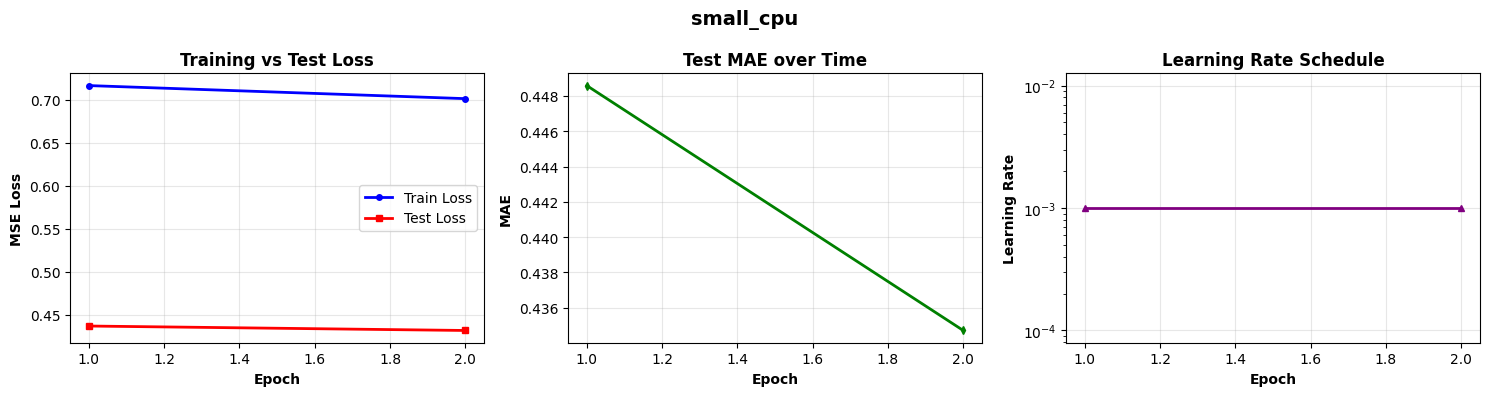

In [29]:
plot_training_history('all_experiments.json', experiment_name='small_cpu', experiment_dir='./experiments')

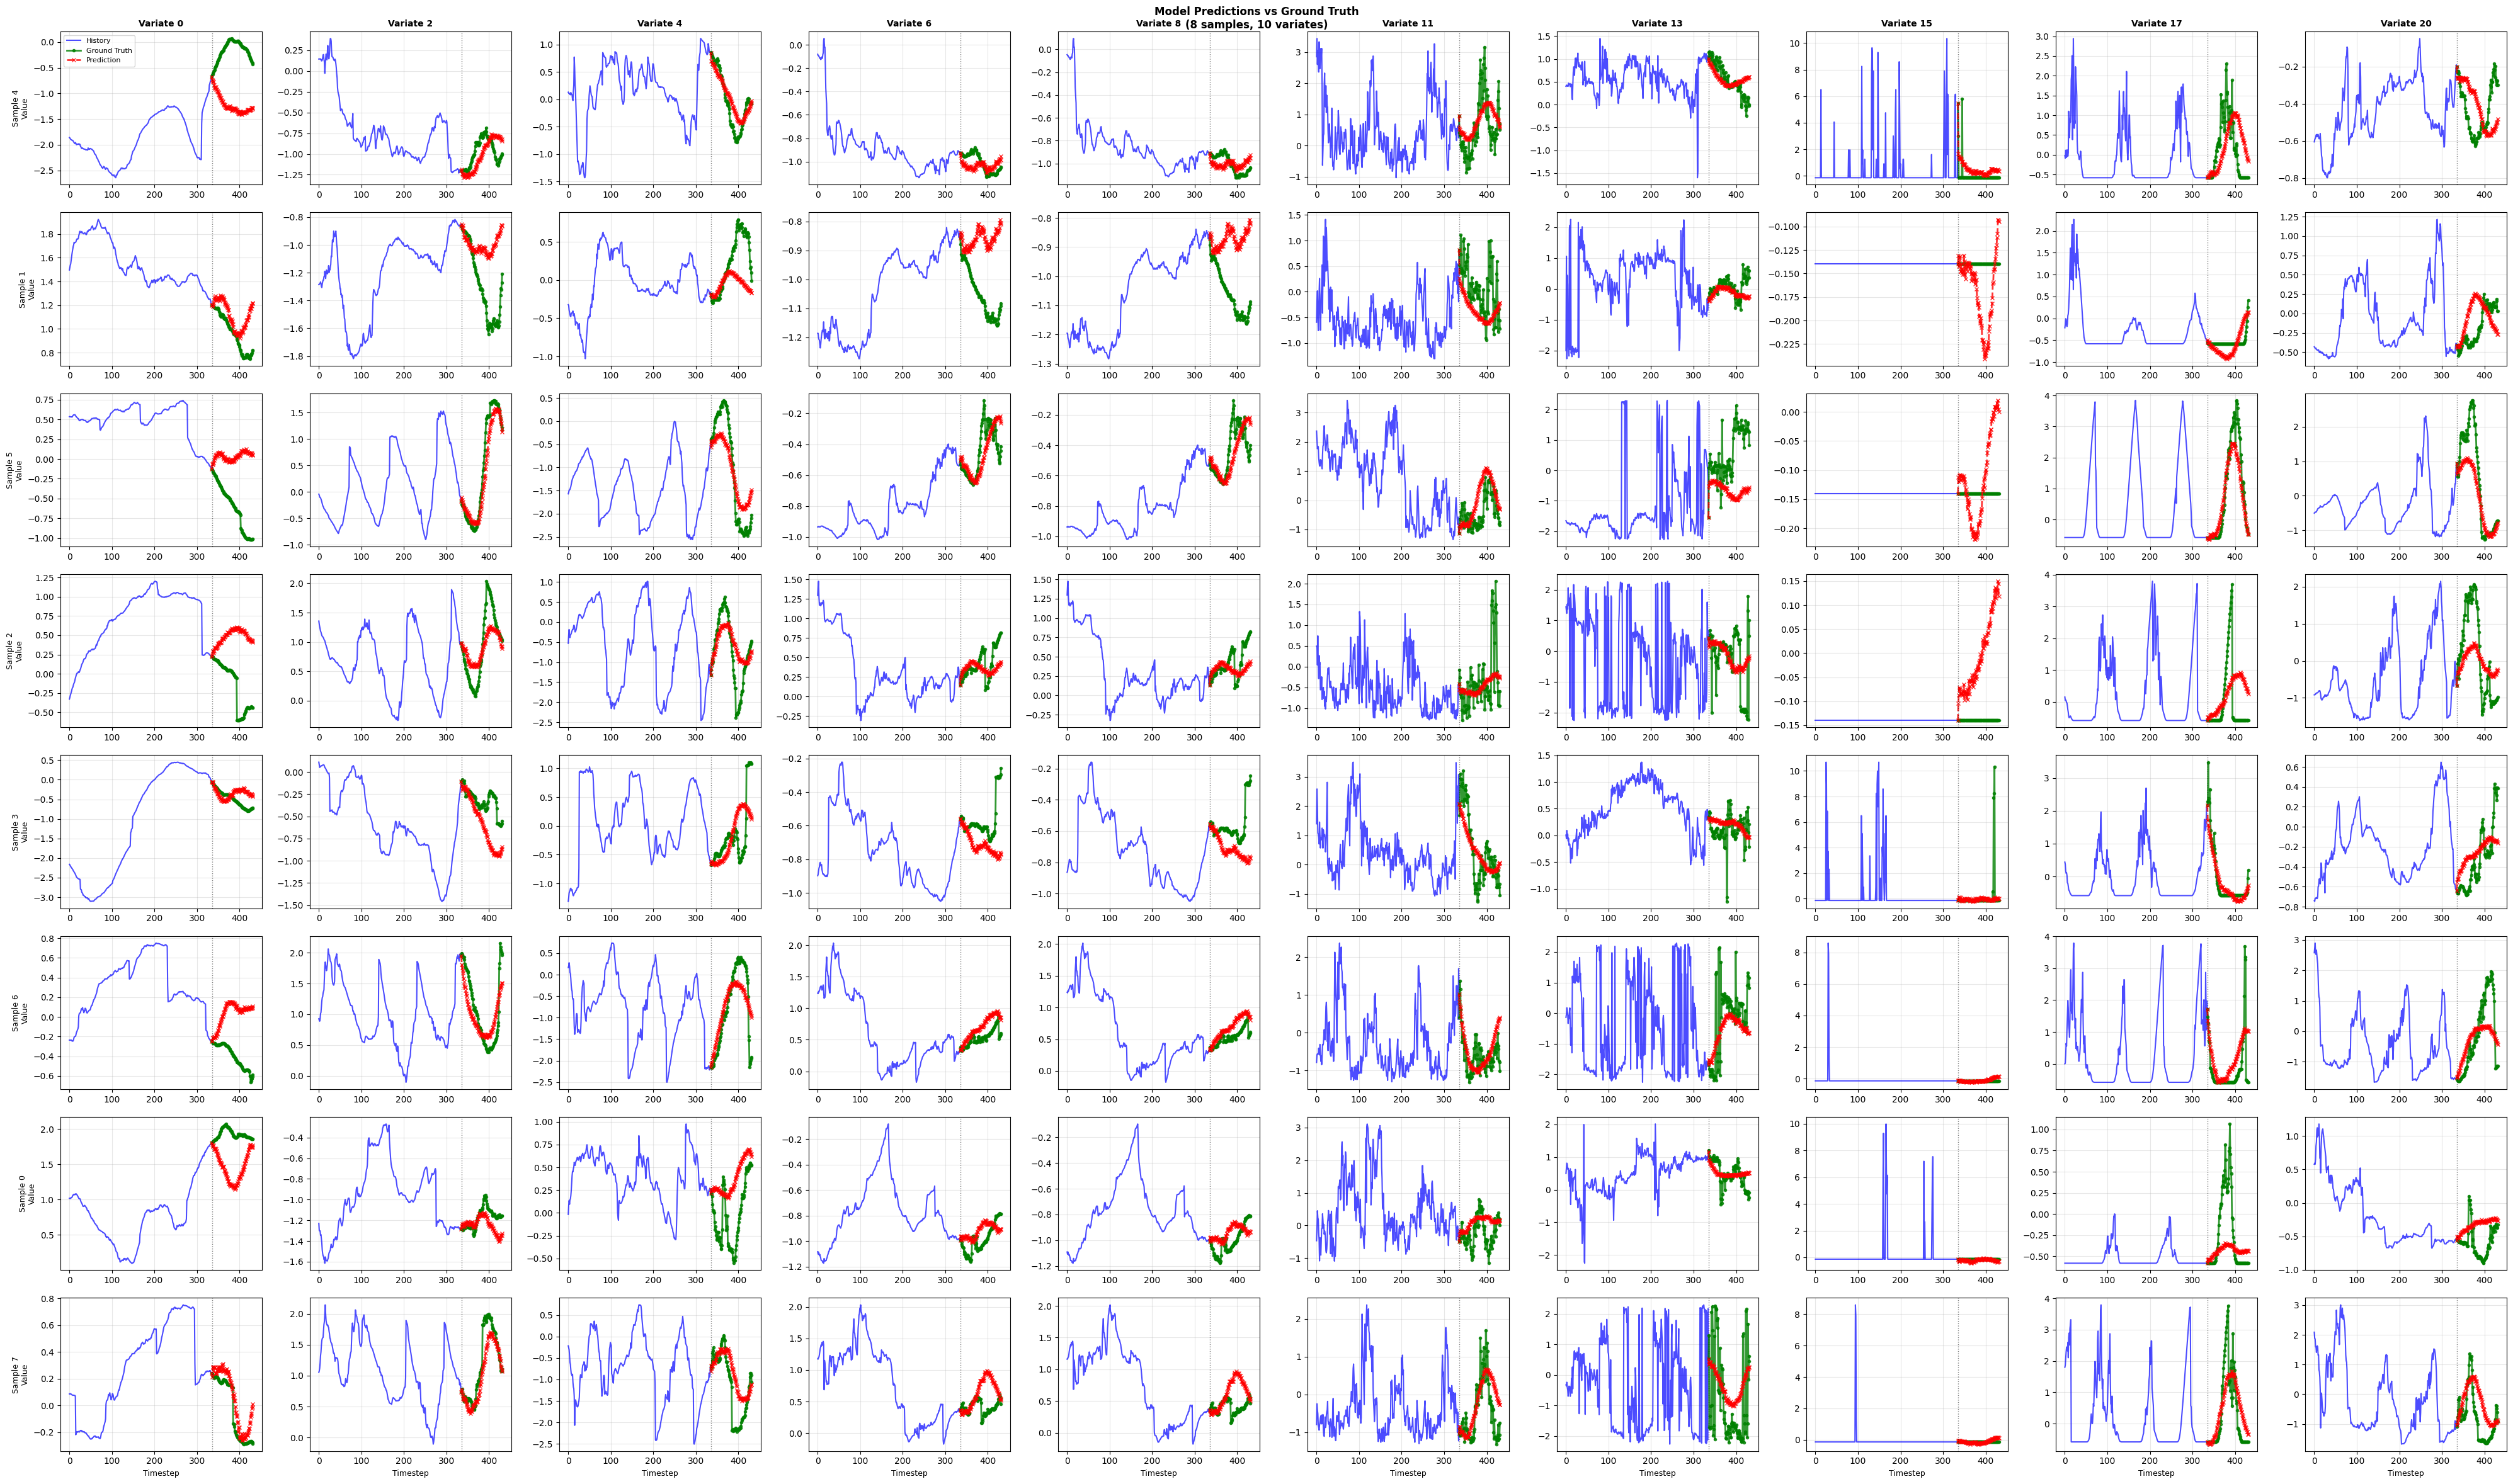

In [32]:
visualize_predictions(
    model=model,
    data_loader=train_loader,
    device='cpu',
    num_samples=10,
    num_variates=10,
    save_path=None
)

In [ ]:
# Print all experiments in file
print_experiment_summary('all_experiments.json')

# Print specific experiment
print_experiment_summary('all_experiments.json', experiment_name='test_small_cpu')

# Plot specific experiment
plot_training_history('all_experiments.json', experiment_name='test_small_cpu')

# Compare specific experiments
compare_experiments('all_experiments.json', experiment_names=['baseline_v1', 'with_skip']) # no exeriment_name -> all experiments

## Hyper-param search

In [ ]:
hyperparam_grid = {
    # Model architecture
    'd_model': [64, 128, 256],                    # Embedding dimension
    'n_layers': [2, 3],                           # Depth (same for both streams)
    'dropout': [0.3],                   # Regularization
    
    # Powerformer-specific
    'patch_len': [4, 8, 16],                      # Temporal patch size
    'stride': [4, 8],                             # Patch stride (stride=patch_len/2 is common)
    'attn_decay_scale': [0.1, 0.25, 0.5],        # Power-law decay (alpha)
    
    # Training
    'learning_rate': [1e-4, 5e-4, 1e-3],
    'weight_decay': [1e-4, 1e-3],
}

MAX_TRIALS = 20  # Limit number of trials (random sample if > total combinations)
NUM_EPOCHS = 10  # Epochs per trial (keep low for speed)
RESULTS_FILE = 'hyperparam_search.json'

# Generate parameter combinations
all_combinations = list(itertools.product(*hyperparam_grid.values()))
param_names = list(hyperparam_grid.keys())

total_combinations = 1
for values in hyperparam_grid.values():
    total_combinations *= len(values)

print(f"Total hyperparameter combinations: {total_combinations}")
selected_combinations = all_combinations
print(f"Testing all {len(all_combinations)} combinations")

Start search

In [ ]:
for trial_idx, params in enumerate(selected_combinations, 1):
    # Convert to dict
    config = dict(zip(param_names, params))
    
    print(f"TRIAL {trial_idx}/{len(selected_combinations)}")
    print(f"Config: {config}")
    
    # Derived hyperparameters (following best practices)
    n_heads = 4 if config['d_model'] <= 128 else 8  # Must divide d_model
    d_ff = config['d_model'] * 4  # Standard: 4x d_model
    
    try:
        # Initialize model with current hyperparameters
        model = Model(
            num_variates=data_normalized.shape[1],
            lookback_steps=LOOKBACK_STEPS,
            forecast_steps=FORECAST_STEPS,
            skip_connections=True,  # Keep skip connections on
            
            d_model=config['d_model'],
            
            # Stream 1: iTransformer
            n_heads_s1=n_heads,
            n_layers_s1=config['n_layers'],
            d_ff_s1=d_ff,
            dropout_s1=config['dropout'],
            
            # Stream 2: Powerformer
            patch_len=config['patch_len'],
            stride=config['stride'],
            n_heads_s2=n_heads,
            n_layers_s2=config['n_layers'],
            d_ff_s2=d_ff,
            dropout_s2=config['dropout'],
            attn_decay_scale=config['attn_decay_scale'],
            
            # Fusion
            n_heads_fusion=n_heads // 2,  # Half of stream heads
        )
        
        # Initialize trainer
        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            learning_rate=config['learning_rate'],
            weight_decay=config['weight_decay']
        )
        
        # Train
        history = trainer.train(
            num_epochs=NUM_EPOCHS,
            use_scheduler=True,
            scheduler_factor=0.5,
            scheduler_patience=2,
            save_dir='./experiments',
            save_metrics=True,
            experiment_name=f"trial_{trial_idx}",
            results_file=RESULTS_FILE,
            append_results=True,
            plot_predictions=False,  # Skip plots during search
        )
        
        # Print trial summary
        final_mse = history['test_losses'][-1]
        final_mae = history['test_maes'][-1]
        best_mse = min(history['test_losses'])
        print(f"  Final MSE: {final_mse:.6f} | Best MSE: {best_mse:.6f} | Final MAE: {final_mae:.6f}")
        
    except Exception as e:
        print(f"  FAILED: {str(e)}")
        continue
    
    print(f"{'-'*80}\n")

print(f"\n{'='*80}")
print("Hyperparameter search completed!")
print(f"Results saved to: {RESULTS_FILE}")
print(f"{'='*80}\n")
